# From Scripts to Programs: Python Beyond Scripting

Real Python programming is not about syntax tricks.
It is about writing code that is readable, testable, reusable, and robust—code that other people (including your future self) can understand and extend.

The following tools and habits are not advanced features; they are baseline practices used in scientific, engineering, and production Python code.
They help structure programs, make assumptions explicit, prevent silent errors, and support collaboration.

You do not need all of them all the time—but knowing when and why to use them is what separates scripts from real programs.

## 1) Program entry point

Real Python code is often **imported as a module** *and* run as a script.
To control this, we separate:

- **definition** of functionality
- **execution** of a program

In [20]:
def main():
    print("Running main program logic")

if __name__ == "__main__":
    main()

Running main program logic


#### Why this pattern matters

- If this file is **run directly**, `main()` is executed
- If this file is **imported**, nothing runs automatically

This is essential for:
- reusable modules
- testing
- notebooks importing code

In [21]:
print("Module name is:", __name__)

Module name is: __main__


## 2) Lightweight OOP with `dataclass`

In real Python programs, we rarely pass around dozens of loose parameters.
Instead, we **group related data** into small, explicit objects.

Python's `dataclass` gives us:
- readable code
- automatic constructors
- minimal boilerplate

This is *not* heavy OOP — it's structured data with intent.

In [22]:
from dataclasses import dataclass

@dataclass(frozen=True)
class Config:
    dt: float = 0.1
    nsteps: int = 5
    method: str = "euler"

cfg = Config(dt=0.2, nsteps=3)
print(cfg)

Config(dt=0.2, nsteps=3, method='euler')


## 3) Functions as first-class objects

In Python, functions are *values*:
- they can be passed as arguments
- stored in variables
- swapped at runtime

This enables **plug-in style design** without large class hierarchies.

In [23]:
def step_euler(x, dt):
    return x + dt * (-x)

def step_rk2(x, dt):
    k1 = -x
    k2 = -(x + dt*k1)
    return x + 0.5*dt*(k1 + k2)

def simulate(x0, dt, nsteps, stepper):
    x = x0
    for _ in range(nsteps):
        x = stepper(x, dt)
    return x

print("Euler:", simulate(1.0, 0.2, 5, step_euler))
print("RK2:  ", simulate(1.0, 0.2, 5, step_rk2))

Euler: 0.32768
RK2:   0.37073984319999986


## 4) Type hints

Type hints do **not** change runtime behavior.
They are for:
- humans
- IDEs
- refactoring safety

They let us *think* more like static languages without losing Python's flexibility.

In [24]:
from typing import Callable

Stepper = Callable[[float, float], float]

def simulate_typed(x0: float, dt: float, nsteps: int, stepper: Stepper) -> float:
    x: float = x0
    for _ in range(nsteps):
        x = stepper(x, dt)
    return x

simulate_typed(1.0, 0.1, 3, step_euler)

0.7290000000000001

## 5) Decorators

Python allows us to *wrap behavior* around functions
using **decorators** — a powerful but lightweight abstraction.
A decorator is a **function that wraps another function**
to add behavior *without modifying the original function body*.

They are heavily used for:
- logging
- timing
- validation
- access control

In [ ]:
def log_call(func):
    def wrapper(*args, **kwargs):
        print(f"Calling {func.__name__}")
        return func(*args, **kwargs)
    return wrapper

Using the decorator

In [ ]:
@log_call
def compute(x):
    return x * x

compute(3)

#### What just happened?

This:
@log_call
def compute(...)

Is equivalent to:
compute = log_call(compute)

The original function is **wrapped**, not modified.

## 6) Validation and exceptions

Scripts often silently produce nonsense.
Real programs **check assumptions early** and fail loudly.

Python uses exceptions instead of error codes.

In [4]:
def validate(cfg):
    if cfg.dt <= 0:
        raise ValueError("dt must be > 0")
    if cfg.nsteps < 1:
        raise ValueError("nsteps must be >= 1")
    if cfg.method not in {"euler", "rk2"}:
        raise ValueError("method must be 'euler' or 'rk2'")

cfg_ok = Config(dt=0.1, nsteps=3, method="euler")
validate(cfg_ok)
print("Config OK")

try:
    cfg_bad = Config(dt=-0.1, nsteps=3, method="euler")
    validate(cfg_bad)
except ValueError as e:
    print("Validation failed:", e)

Config OK
Validation failed: dt must be > 0


Or use the a decorator:

In [ ]:
def validate(cfg):
    if cfg.dt <= 0:
        raise ValueError("dt must be > 0")
    if cfg.nsteps < 1:
        raise ValueError("nsteps must be >= 1")
    if cfg.method not in {"euler", "rk2"}:
        raise ValueError("method must be 'euler' or 'rk2'")

def validate_config(func):
    def wrapper(cfg, *args, **kwargs):
        validate(cfg)
        return func(cfg, *args, **kwargs)
    return wrapper

@validate_config
def run(cfg):
    print("Running with", cfg)

cfg_ok = Config(dt=0.1, nsteps=3, method="euler")
run(cfg_ok)
try:
    cfg_bad = Config(dt=-0.1, nsteps=3, method="euler")
    run(cfg_bad)
except ValueError as e:
    print("Validation failed:", e)

Running with Config(dt=0.1, nsteps=3, method='euler')
Validation failed: dt must be > 0


## 7) Logging (instead of print)

`print()` does not scale:
- no severity levels
- no timestamps
- hard to disable

Logging gives structured, controllable output.

In [5]:
import logging

logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(name)s:%(message)s")
log = logging.getLogger("demo")

def run(cfg):
    validate(cfg)
    stepper = step_euler if cfg.method == "euler" else step_rk2
    log.info("Starting run: %s", cfg)
    x = simulate_typed(1.0, cfg.dt, cfg.nsteps, stepper)
    log.info("Finished. x=%.6f", x)
    return x

run(Config(dt=0.2, nsteps=5, method="rk2"))

INFO:demo:Starting run: Config(dt=0.2, nsteps=5, method='rk2')
INFO:demo:Finished. x=0.370740


0.37073984319999986

Or using decorators

In [29]:
def log_run(func):
    def wrapper(*args, **kwargs):
        log.info("Starting %s", func.__name__)
        result = func(*args, **kwargs)
        log.info("Finished %s", func.__name__)
        return result
    return wrapper

@log_run
@validate_config
def run(cfg):
    stepper = step_euler if cfg.method == "euler" else step_rk2
    x = simulate_typed(1.0, cfg.dt, cfg.nsteps, stepper)
    log.info("Result x = %.6f", x)
    return x

run(Config(dt=0.2, nsteps=5, method="rk2"))

INFO:demo:Starting wrapper
INFO:demo:Result x = 0.370740
INFO:demo:Finished wrapper


0.37073984319999986

Order matters:
- validate_config runs first
- log_run wraps the whole execution

(Decorators apply bottom-up.)

## 8) Testing mindset (very small)

A test is just:
- deterministic input
- expected behavior
- an assertion

Even one test changes how people write code.

In [6]:
def test_rk2_is_better_than_euler():
    cfg = Config(dt=0.5, nsteps=4)
    x_e = simulate_typed(1.0, cfg.dt, cfg.nsteps, step_euler)
    x_r = simulate_typed(1.0, cfg.dt, cfg.nsteps, step_rk2)

    import math
    t = cfg.dt * cfg.nsteps
    x_true = math.exp(-t)

    assert abs(x_r - x_true) < abs(x_e - x_true)

test_rk2_is_better_than_euler()
print("test passed")

test passed


## 9) Performance awareness

Performance is about **structure**, not micro-optimizations.
Measure first, then decide.
Timing is a *cross-cutting concern*:
we want to measure runtime **without modifying the computation itself**.


In [7]:
import time

def bench(stepper, label):
    t0 = time.perf_counter()
    x = simulate_typed(1.0, 1e-3, 200_000, stepper)
    t1 = time.perf_counter()
    print(f"{label:5s}: {t1-t0:.3f}s  (x={x:.4f})")

bench(step_euler, "Euler")
bench(step_rk2,   "RK2")

Euler: 0.014s  (x=0.0000)
RK2  : 0.021s  (x=0.0000)


### Timing with a decorator (this is the prime example for decorators)

In [32]:
import time

def timed(func):
    def wrapper(*args, **kwargs):
        t0 = time.perf_counter()
        result = func(*args, **kwargs)
        t1 = time.perf_counter()
        print(f"{func.__name__}: {t1-t0:.3f}s")
        return result
    return wrapper

@timed
def run_stepper(stepper):
    return simulate_typed(1.0, 1e-3, 200_000, stepper)

x = run_stepper(step_euler)
print("Euler result:", x)

x = run_stepper(step_rk2)
print("RK2 result:  ", x)

run_stepper: 0.012s
Euler result: 1.2521178201173003e-87
run_stepper: 0.020s
RK2 result:   1.3839426920021943e-87


## 10) Docstrings

Docstrings are **executable documentation**:
- attached directly to functions, classes, and modules
- accessible at runtime
- used by IDEs, help systems, and documentation tools

They explain **what a function does**, not how it does it.

In [33]:
def simulate_typed(x0: float, dt: float, nsteps: int, stepper) -> float:
    """
    Advance a scalar ODE in time.

    Parameters
    ----------
    x0 : float
        Initial value.
    dt : float
        Time step size.
    nsteps : int
        Number of time steps.
    stepper : callable
        Time integration function.

    Returns
    -------
    float
        Final solution value.
    """
    x = x0
    for _ in range(nsteps):
        x = stepper(x, dt)
    return x

#### Why docstrings matter

- They define the **public contract** of a function
- They survive refactoring better than comments
- They enable `help()`, IDE tooltips, and auto-doc generation

# Example Code

INFO:gravity:Starting simulate
INFO:gravity:Finished simulate
INFO:gravity:Starting simulate
INFO:gravity:Finished simulate


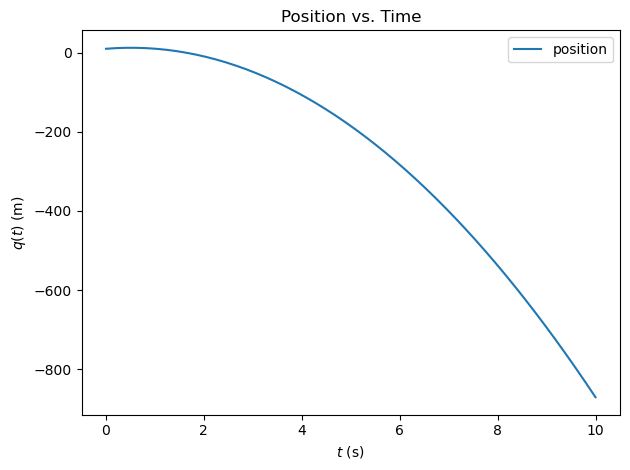

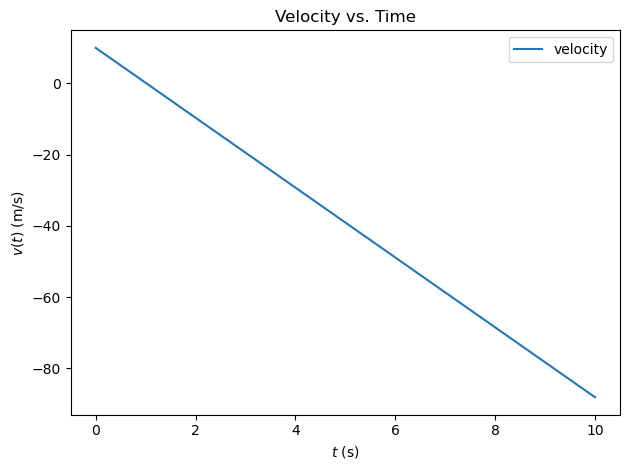

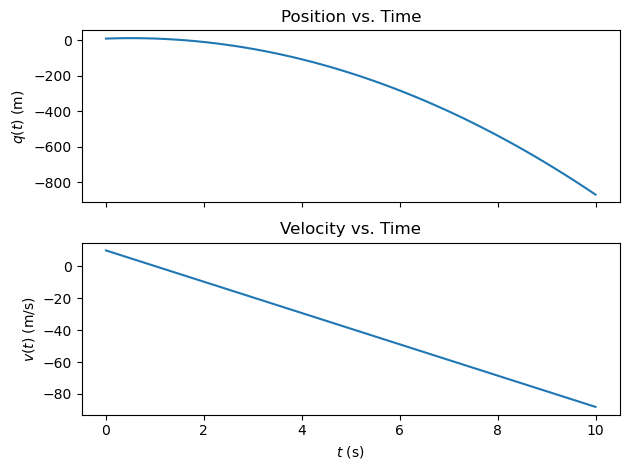

INFO:gravity:main took 0.377 s


In [34]:
"""
Particle motion in a uniform gravity field.
"""
from __future__ import annotations

from dataclasses import dataclass
from functools import wraps
import logging
import time
from typing import Callable

import numpy as np
from matplotlib import pyplot as plt

# Looging (Tip 6)
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(name)s:%(message)s")
log = logging.getLogger("gravity")

# Data model (Tip 2) + docstrings (Tip 10)
@dataclass(frozen=True)
class Config:
    """
    Configuration for a 1D gravity trajectory.

    Attributes
    ----------
    q0 : float
        Initial position [m].
    v0 : float
        Initial velocity [m/s].
    g : float
        Gravity magnitude [m/s^2]. (Positive value; acts downward.)
    t_end : float
        End time [s].
    nsteps : int
        Number of time samples.
    """
    q0: float = 10.0
    v0: float = 10.0
    g: float = 9.81
    t_end: float = 10.0
    nsteps: int = 50

# Validation (Tip 5)
def validate(cfg: Config) -> None:
    """Validate configuration values (fail fast)."""
    if cfg.g <= 0:
        raise ValueError("g must be > 0 (use magnitude of gravity).")
    if cfg.nsteps < 2:
        raise ValueError("nsteps must be >= 2.")
    if cfg.t_end <= 0:
        raise ValueError("t_end must be > 0.")

# Decorators
def requires_valid_config(func: Callable[..., object]) -> Callable[..., object]:
    """Decorator: validate the first argument if it's a Config."""
    @wraps(func)
    def wrapper(cfg: Config, *args, **kwargs):
        validate(cfg)
        return func(cfg, *args, **kwargs)
    return wrapper


def log_run(func: Callable[..., object]) -> Callable[..., object]:
    """Decorator: log start/end of a function call."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        log.info("Starting %s", func.__name__)
        out = func(*args, **kwargs)
        log.info("Finished %s", func.__name__)
        return out
    return wrapper


def timed(func: Callable[..., object]) -> Callable[..., object]:
    """Decorator: time a function call (quick performance awareness)."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        t0 = time.perf_counter()
        out = func(*args, **kwargs)
        t1 = time.perf_counter()
        log.info("%s took %.3f s", func.__name__, t1 - t0)
        return out
    return wrapper

# Core physics
def position(t: np.ndarray, q0: float, v0: float, g: float) -> np.ndarray:
    """
    Position q(t) for constant gravity.

    Parameters
    ----------
    t : np.ndarray
        Time array [s].
    q0 : float
        Initial position [m].
    v0 : float
        Initial velocity [m/s].
    g : float
        Gravity magnitude [m/s^2].

    Returns
    -------
    np.ndarray
        Position array [m].
    """
    return q0 + v0 * t - g * t**2


def velocity(t: np.ndarray, v0: float, g: float) -> np.ndarray:
    """
    Velocity v(t) for constant gravity.

    Parameters
    ----------
    t : np.ndarray
        Time array [s].
    v0 : float
        Initial velocity [m/s].
    g : float
        Gravity magnitude [m/s^2].

    Returns
    -------
    np.ndarray
        Velocity array [m/s].
    """
    return v0 - g * t

# Simulation
@log_run
@requires_valid_config
def simulate(cfg: Config) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate position and velocity on a uniform time grid.

    Returns
    -------
    t : np.ndarray
        Time samples [s].
    q : np.ndarray
        Position samples [m].
    v : np.ndarray
        Velocity samples [m/s].
    """
    t = np.linspace(0.0, cfg.t_end, cfg.nsteps)
    q = position(t, cfg.q0, cfg.v0, cfg.g)
    v = velocity(t, cfg.v0, cfg.g)
    return t, q, v

# Plotting
def plot_results(t: np.ndarray, q: np.ndarray, v: np.ndarray) -> None:
    """Create three plots: q(t), v(t), and a stacked view."""
    # Position
    fig, ax = plt.subplots()
    ax.set_title("Position vs. Time")
    ax.set_xlabel(r"$t$ (s)")
    ax.set_ylabel(r"$q(t)$ (m)")
    ax.plot(t, q, label="position")
    ax.legend(loc="upper right")
    fig.tight_layout()

    # Velocity
    fig, ax = plt.subplots()
    ax.set_title("Velocity vs. Time")
    ax.set_xlabel(r"$t$ (s)")
    ax.set_ylabel(r"$v(t)$ (m/s)")
    ax.plot(t, v, label="velocity")
    ax.legend(loc="upper right")
    fig.tight_layout()

    # Combined
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].set_title("Position vs. Time")
    ax[1].set_title("Velocity vs. Time")
    ax[1].set_xlabel(r"$t$ (s)")
    ax[0].set_ylabel(r"$q(t)$ (m)")
    ax[1].set_ylabel(r"$v(t)$ (m/s)")
    ax[0].plot(t, q, label="position")
    ax[1].plot(t, v, label="velocity")
    fig.tight_layout()

# Tiny test
def test_initial_conditions() -> None:
    """Quick regression check: initial q and v match the config."""
    cfg = Config(q0=10.0, v0=10.0, g=9.81, t_end=1.0, nsteps=10)
    t, q, v = simulate(cfg)
    assert np.isclose(q[0], cfg.q0)
    assert np.isclose(v[0], cfg.v0)

# Entry point
@timed
def main() -> None:
    """Run the demo simulation and show plots."""
    test_initial_conditions()  # tiny sanity check
    cfg = Config()
    t, q, v = simulate(cfg)
    plot_results(t, q, v)
    plt.show()


if __name__ == "__main__":
    main()